## Import packages

In [1]:
%matplotlib inline

# import packages
import numpy as np
from scipy.optimize import curve_fit

from scipy import interpolate
from sklearn import linear_model
from multiprocessing import Pool
from random import shuffle
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec

from astropy.io import fits


In [2]:
# define plot properties
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       "purple", rgb(10,10,10), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (15,7.5)
rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.size'] = 25
rcParams['font.weight'] = 300

> Restore the trained neural networks and validation sets.

You can also retrain your network (see below, need GPU), update the neural_nets/folder, accordingly and reinstall the package.


In [3]:
from MWM_Classifier import utils
from MWM_Classifier import testing

# trained models
model_IR, model_optical, training_loss_IR, validation_loss_IR,\
    training_loss_optical, validation_loss_optical = utils.read_in_neural_network()

# validation sets
x_valid_IR, y_valid_IR, x_valid_optical, y_valid_optical = utils.read_in_validation_spectra()


Number of features before the dense layers: 207
Number of features before the dense layers: 62


> Check the training/validation loss.

The network overfit after ~500-1000 epochs. We adopted the NN that has the lowest validation loss (not training loss).

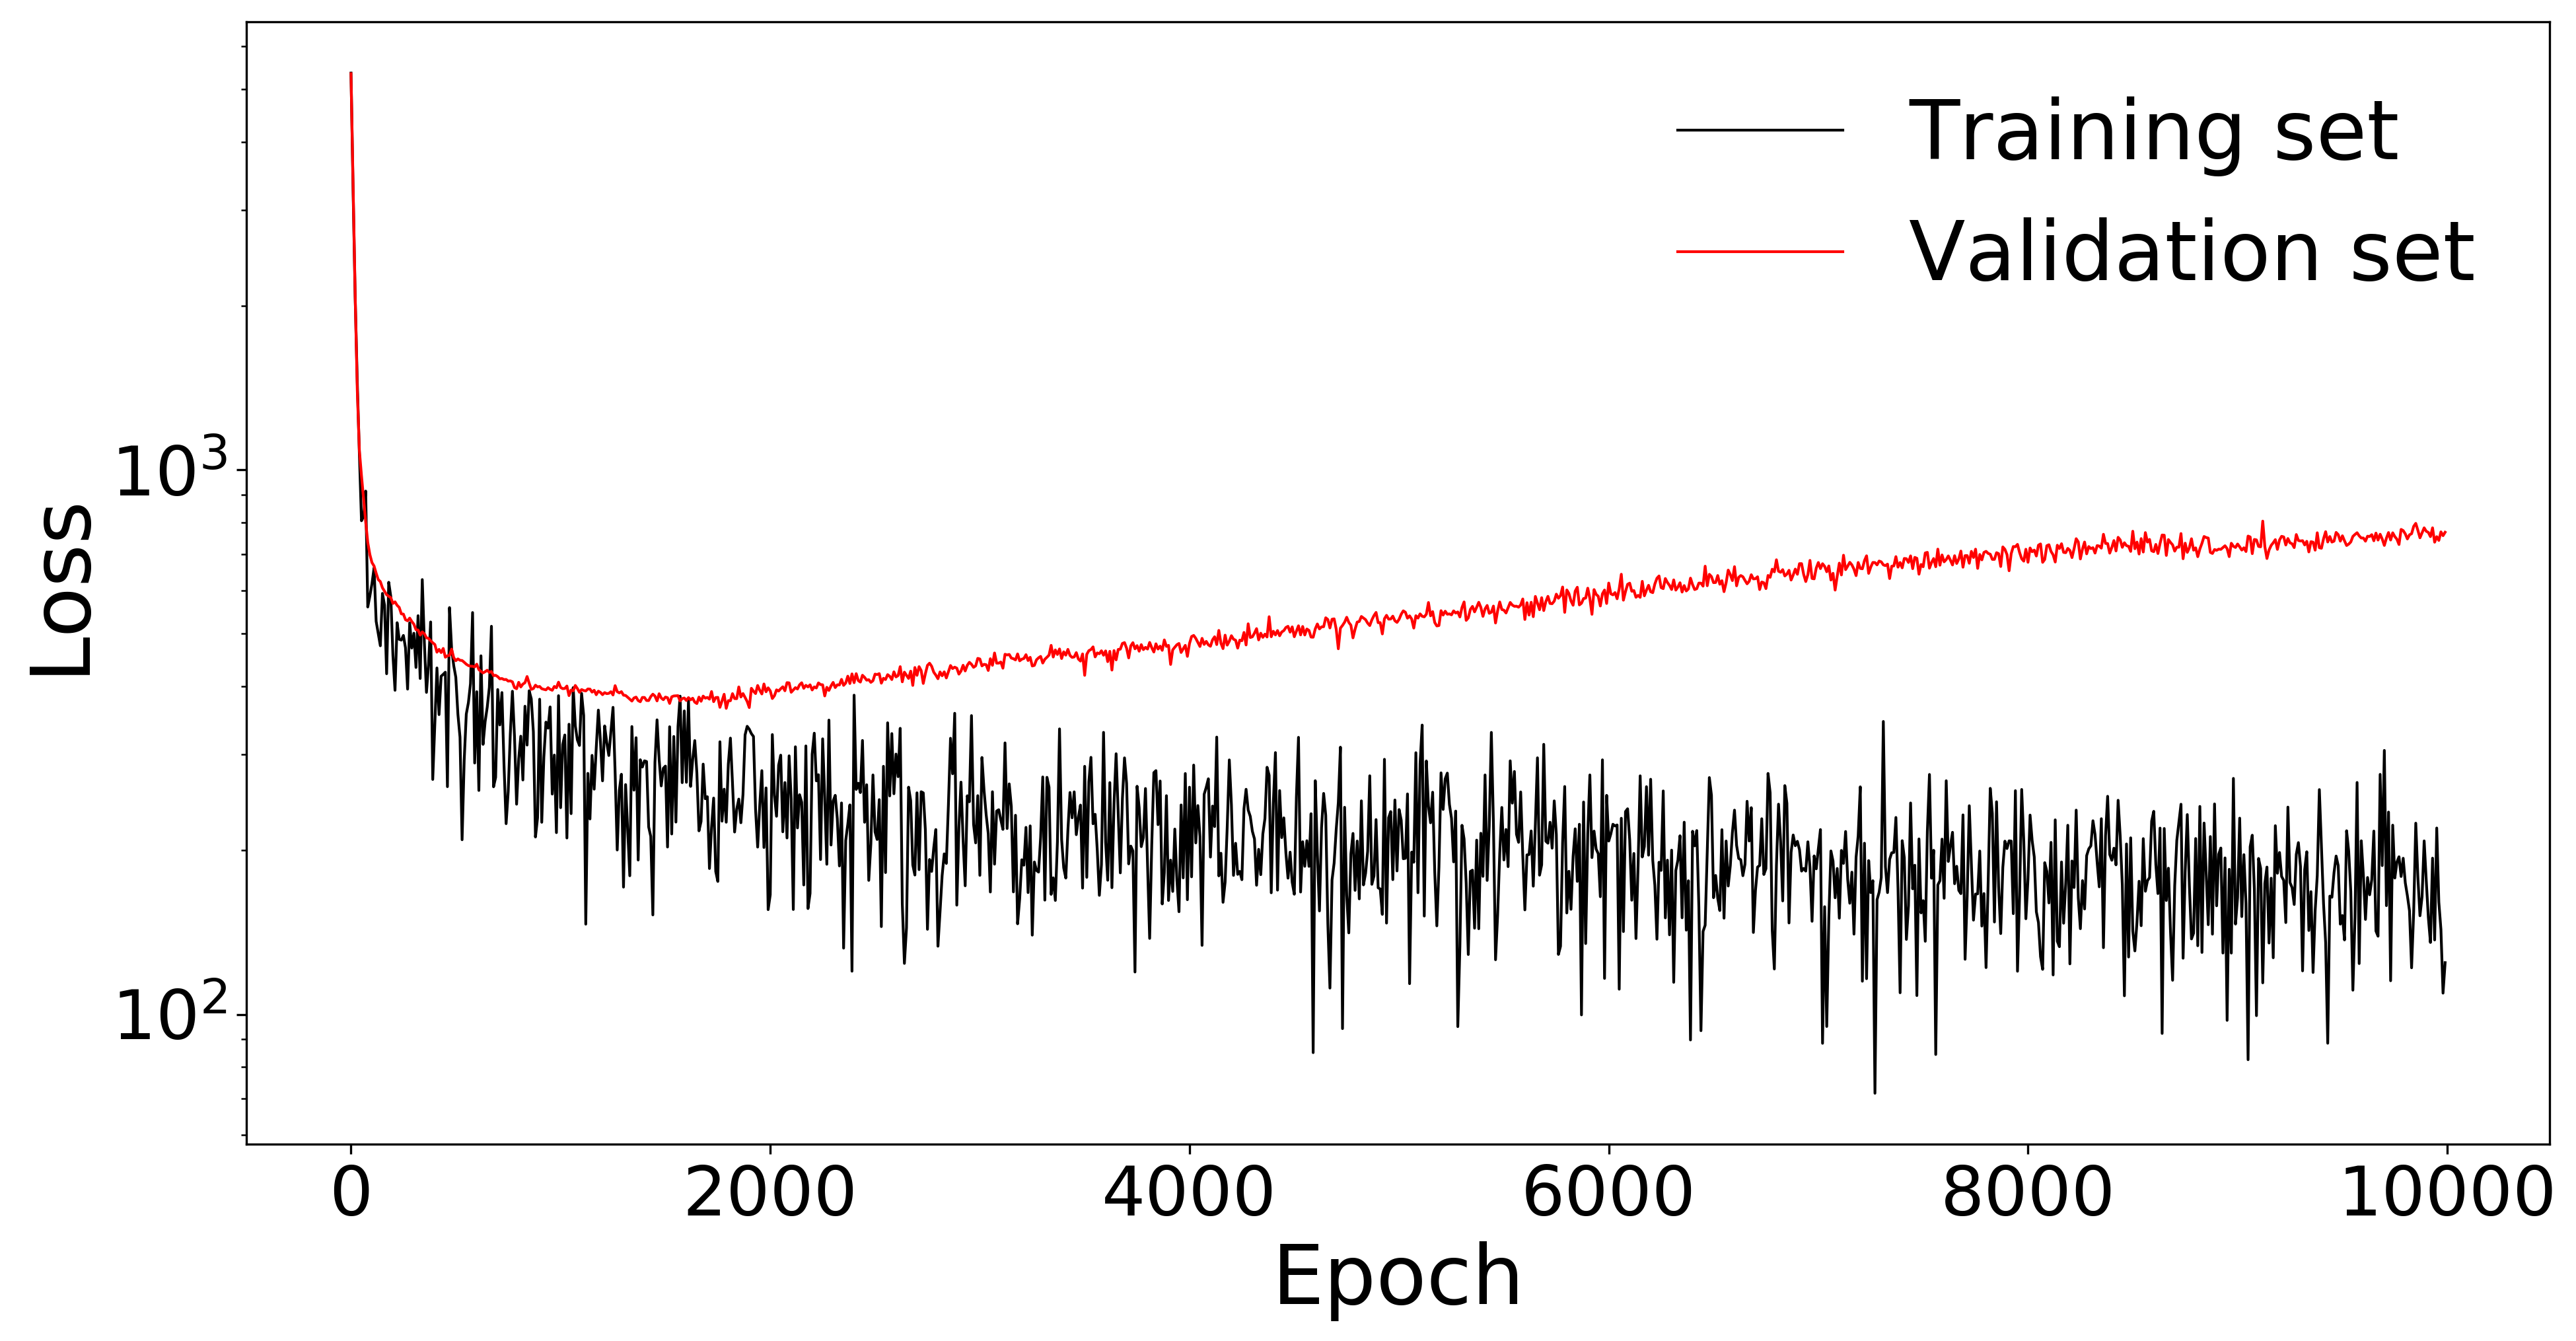

In [4]:
plt.plot(np.arange(training_loss_optical.size)*10, training_loss_optical, 'k', label = 'Training set')
plt.plot(np.arange(training_loss_optical.size)*10, validation_loss_optical, 'r', label = 'Validation set')
plt.legend(loc = 'best', frameon = False, fontsize= 30)
plt.xlabel("Epoch", size=30)
plt.ylabel("Loss", size=30)
plt.yscale('log')

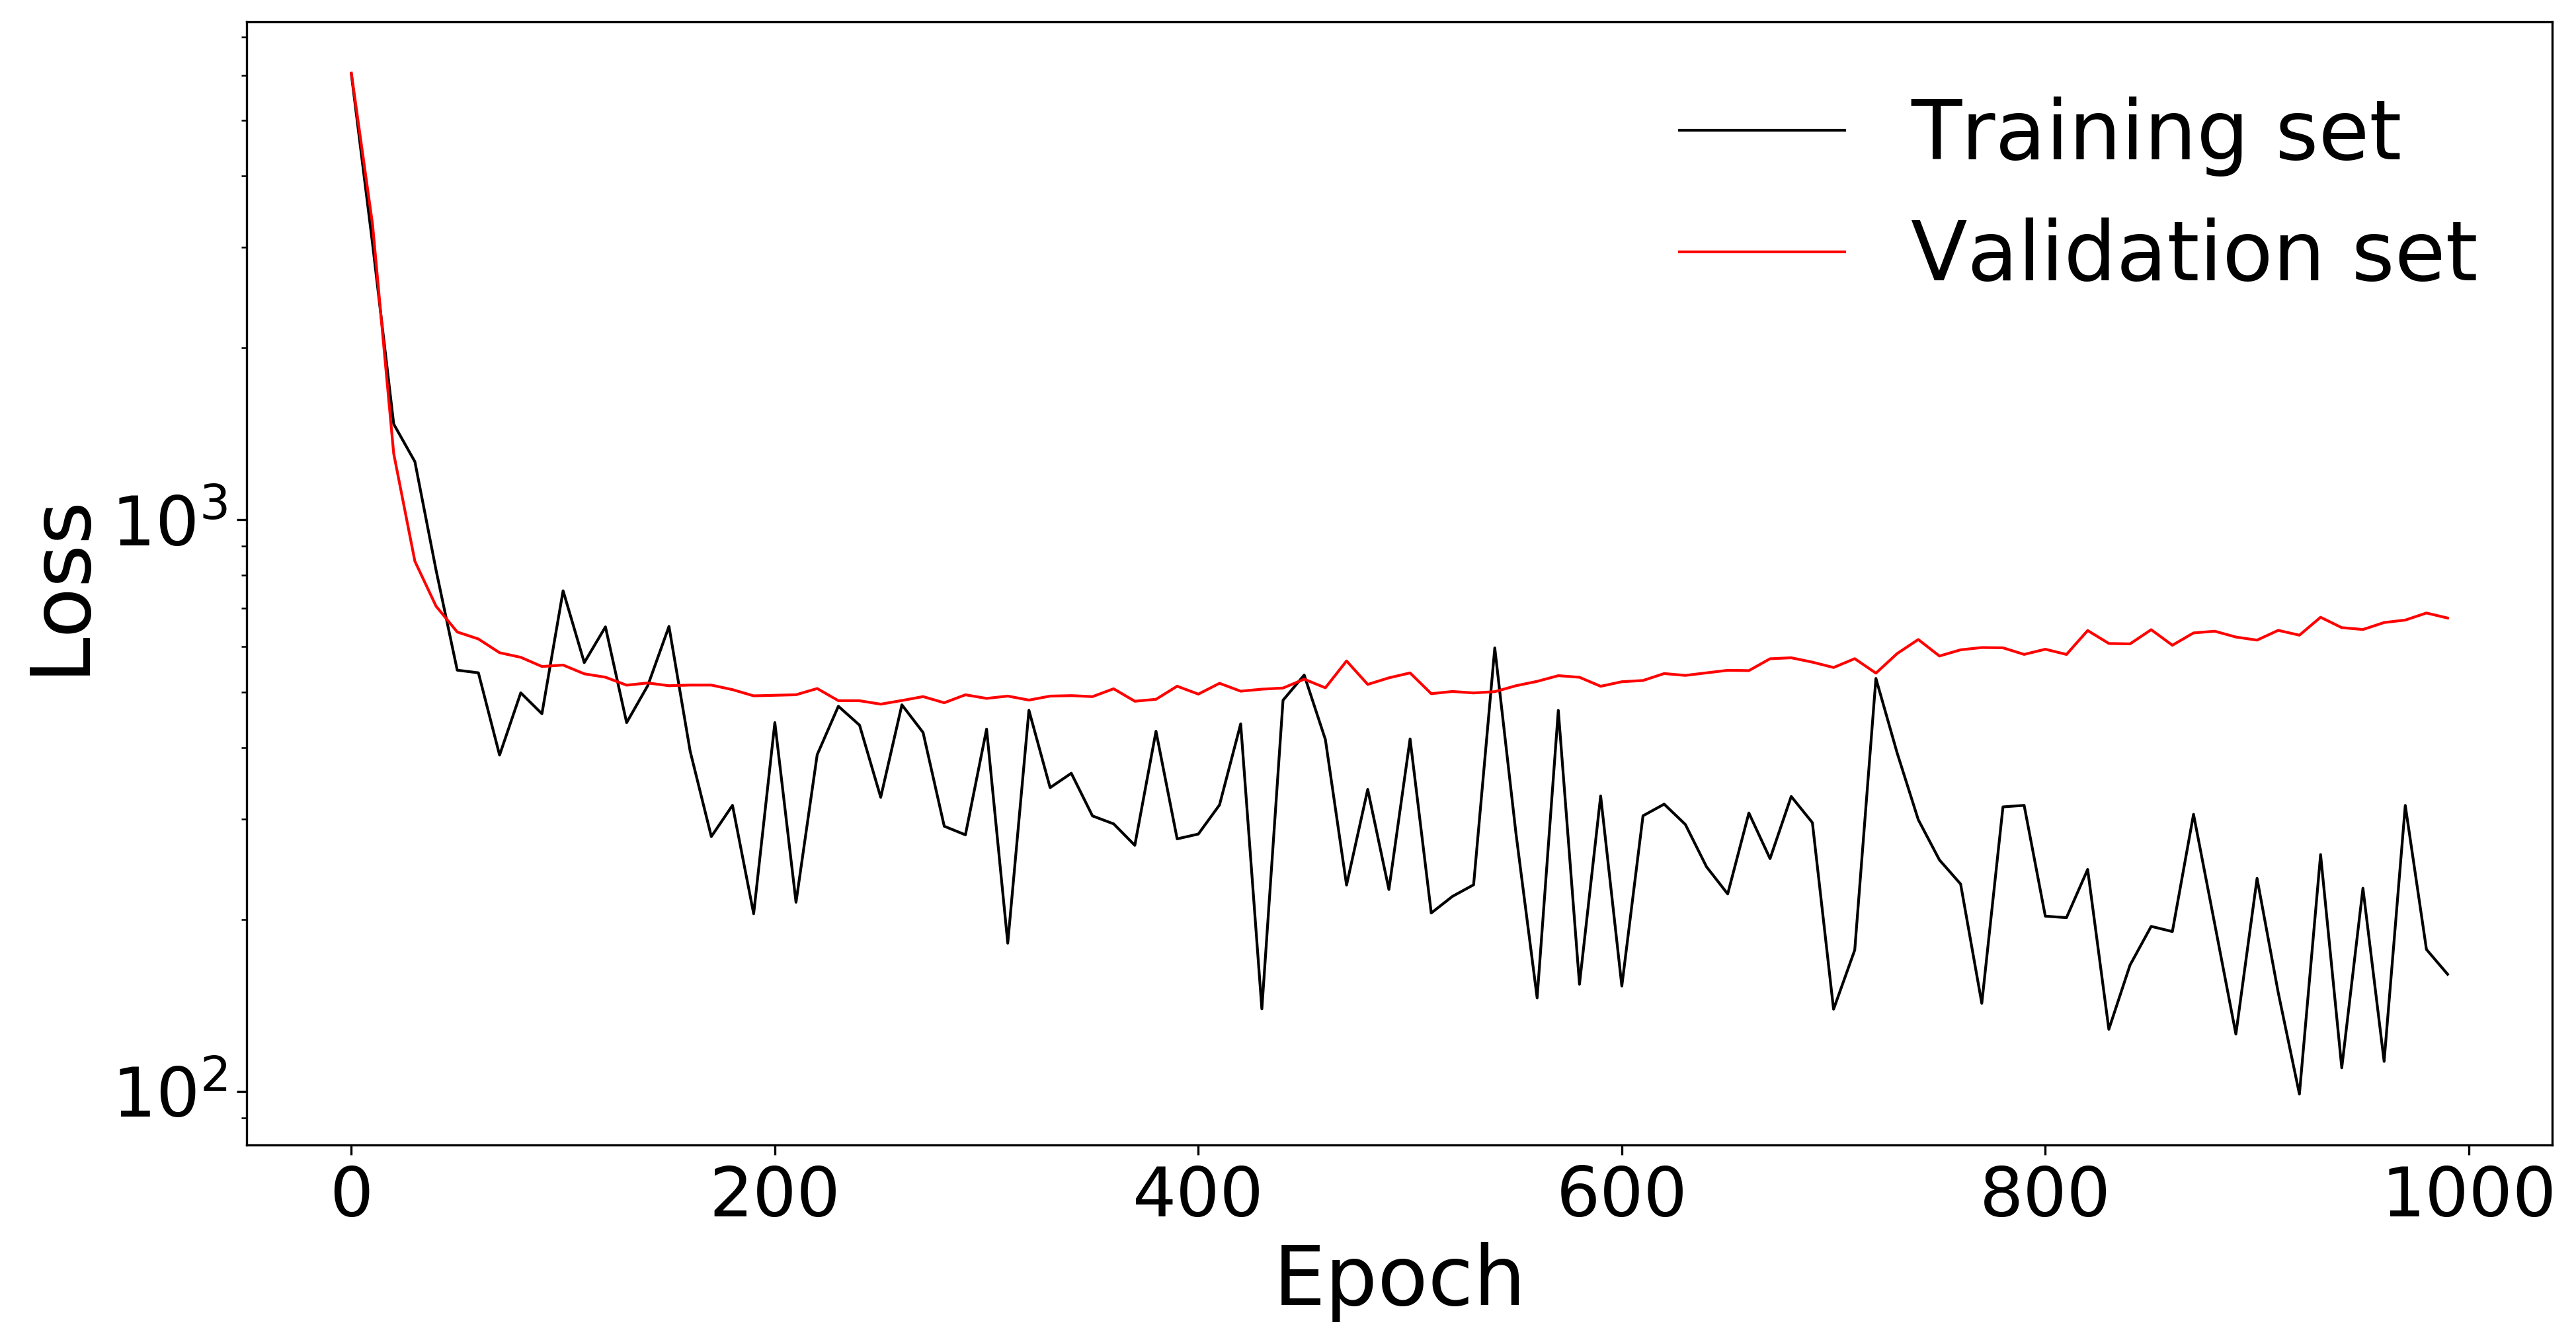

In [5]:
plt.plot(np.arange(training_loss_IR.size)*10, training_loss_IR, 'k', label = 'Training set')
plt.plot(np.arange(training_loss_IR.size)*10, validation_loss_IR, 'r', label = 'Validation set')
plt.legend(loc = 'best', frameon = False, fontsize= 30)
plt.xlabel("Epoch", size=30)
plt.ylabel("Loss", size=30)
plt.yscale('log')

> Process an IR spectrum.

Reading in: apVisit-r8-4914-55807-100.fits


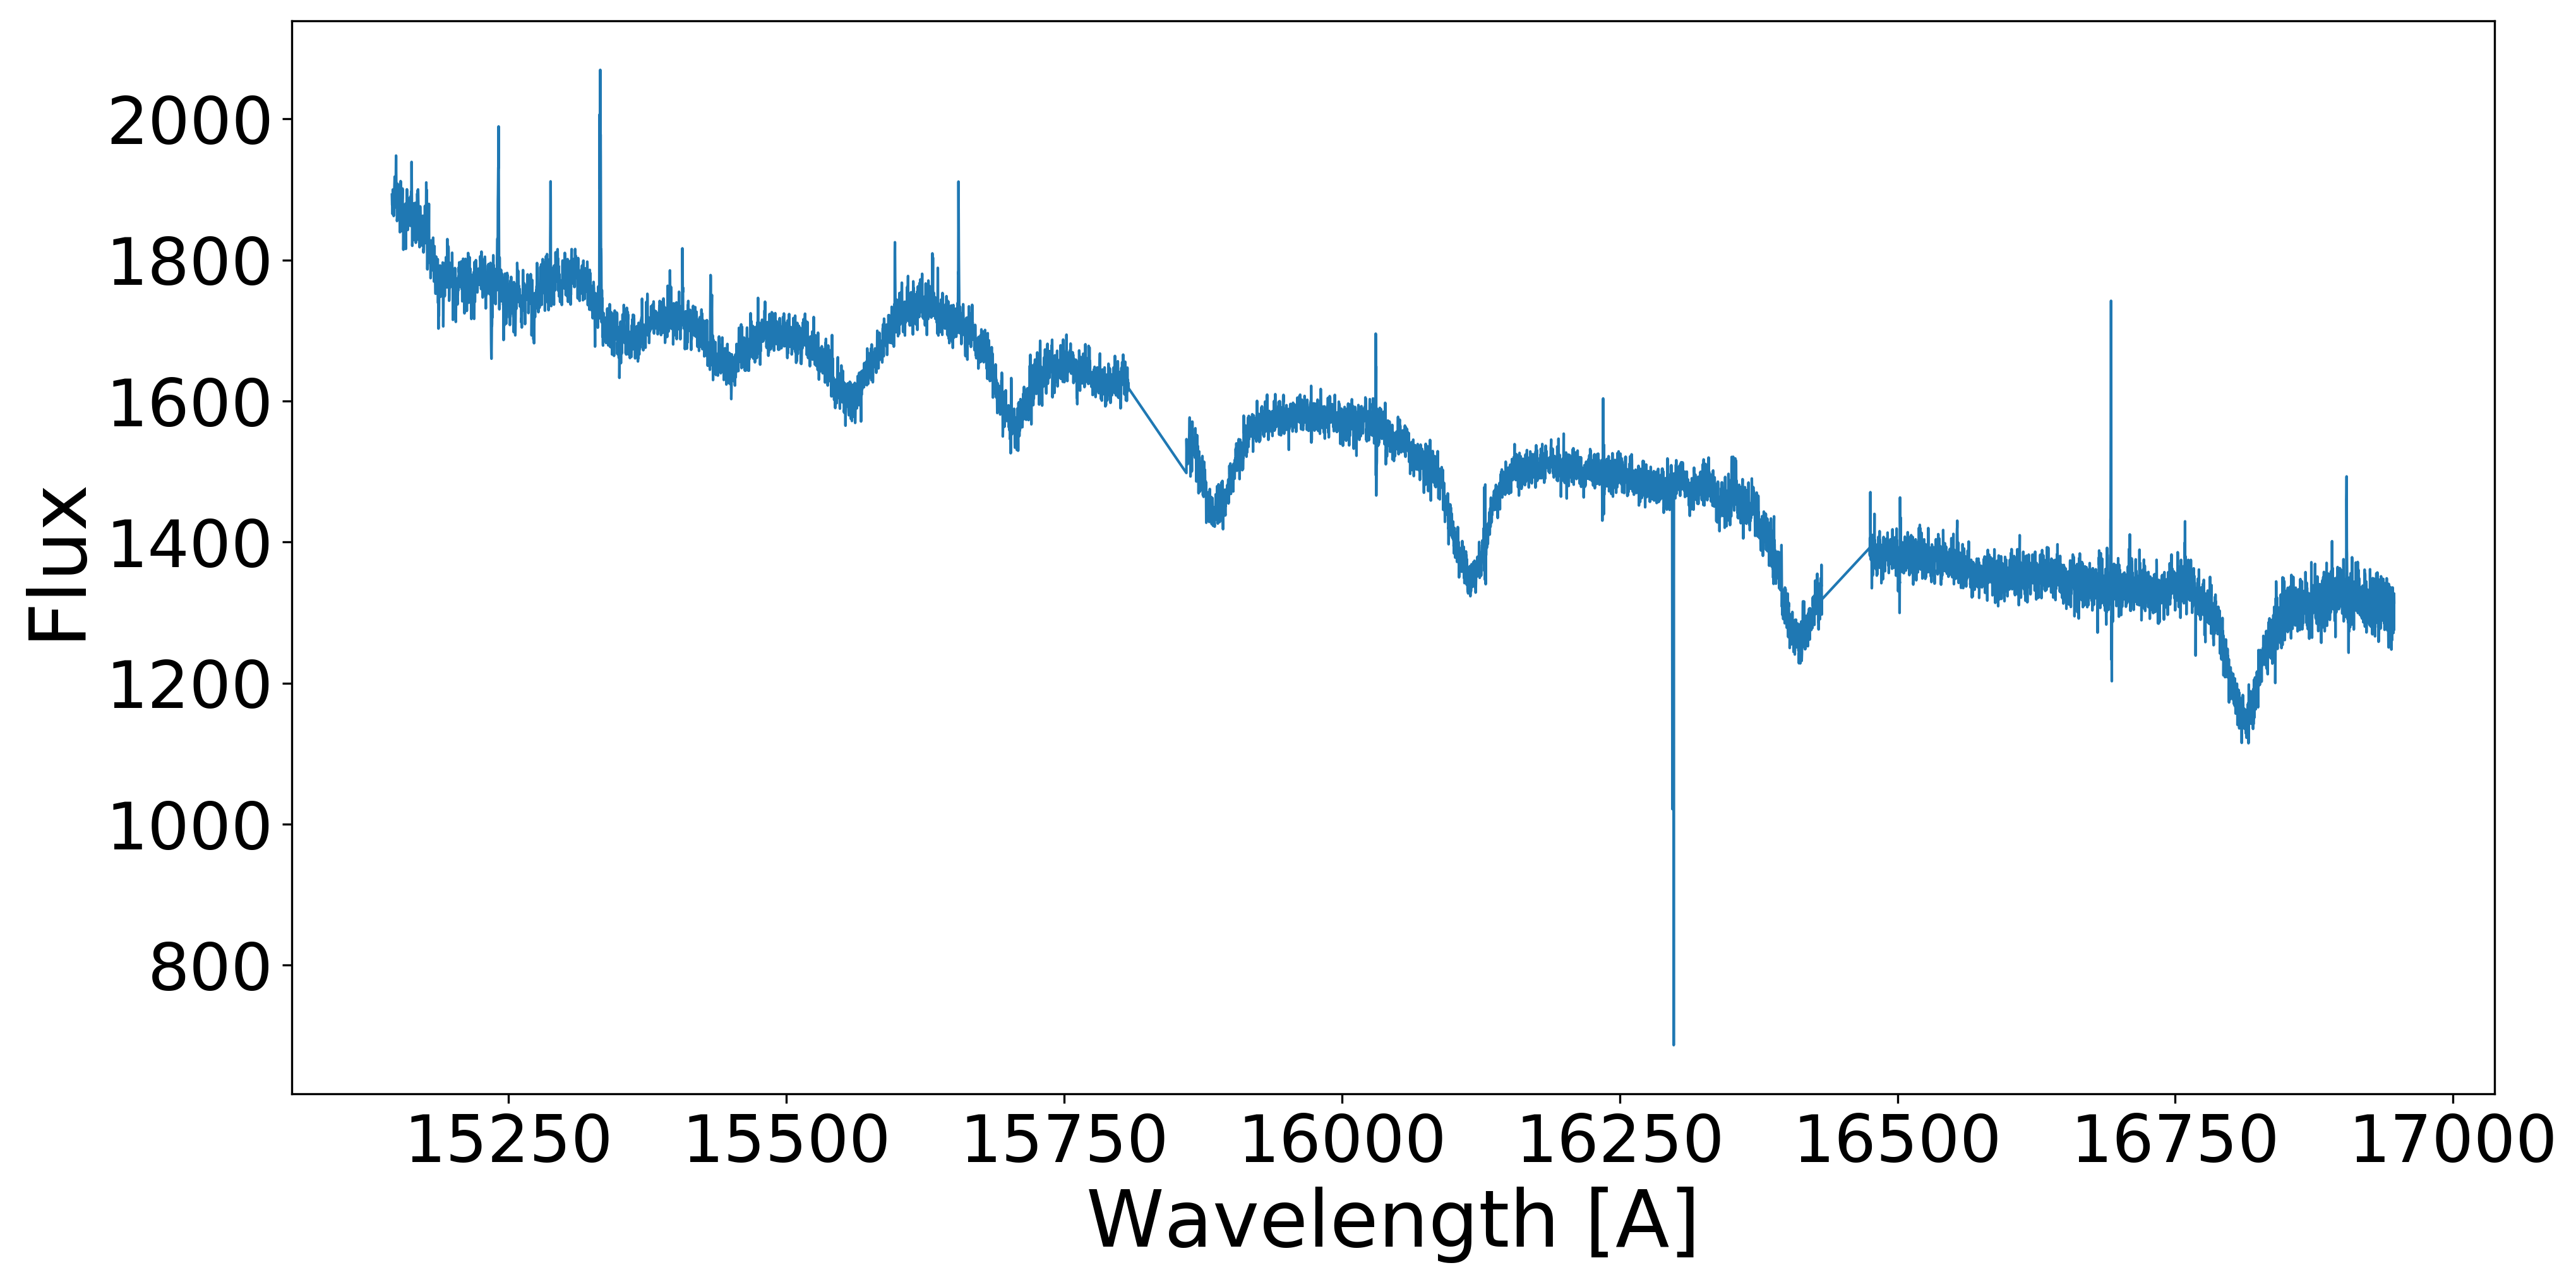

In [6]:
# a hot star
wavelength, flux, flux_err, mask = utils.read_in_IR_example()
    
# standardize the wavelength grid
wavelength, spectrum = utils.standardize_IR_spectrum(wavelength,flux)

# plot the spectrum
plt.xlabel("Wavelength [A]", size=30)
plt.ylabel("Flux", size=30)
plt.plot(wavelength, spectrum)


> Predict the class of this spectrum.

The prediction does suggest that this is indeed a hot star spectrum.

In [7]:
# median normalize the spectrum, the same way as the neural network training input 
spectrum_normalized = spectrum/float(np.median(spectrum)) - 1

# predict the class
prediction_class = testing.predict_class(scaled_spectra = np.array([spectrum_normalized]),\
                            model = model_IR).data.numpy()

print("Probability of class [FGKM, Hot Stars, YSO, SB2] = [", 
        "%.2f " %(prediction_class[0][0]*100.),\
        "%.2f " %(prediction_class[0][1]*100.),\
        "%.2f " %(prediction_class[0][2]*100.),\
        "%.2f " %(prediction_class[0][3]*100.), "]%")


Probability of class [FGKM, Hot Stars, YSO, SB2] = [ 0.00  100.00  0.01  0.00  ]%


> We perform the same for an optical FGKM spectrum.

Reading in: spec-3586-55181-0220.fits


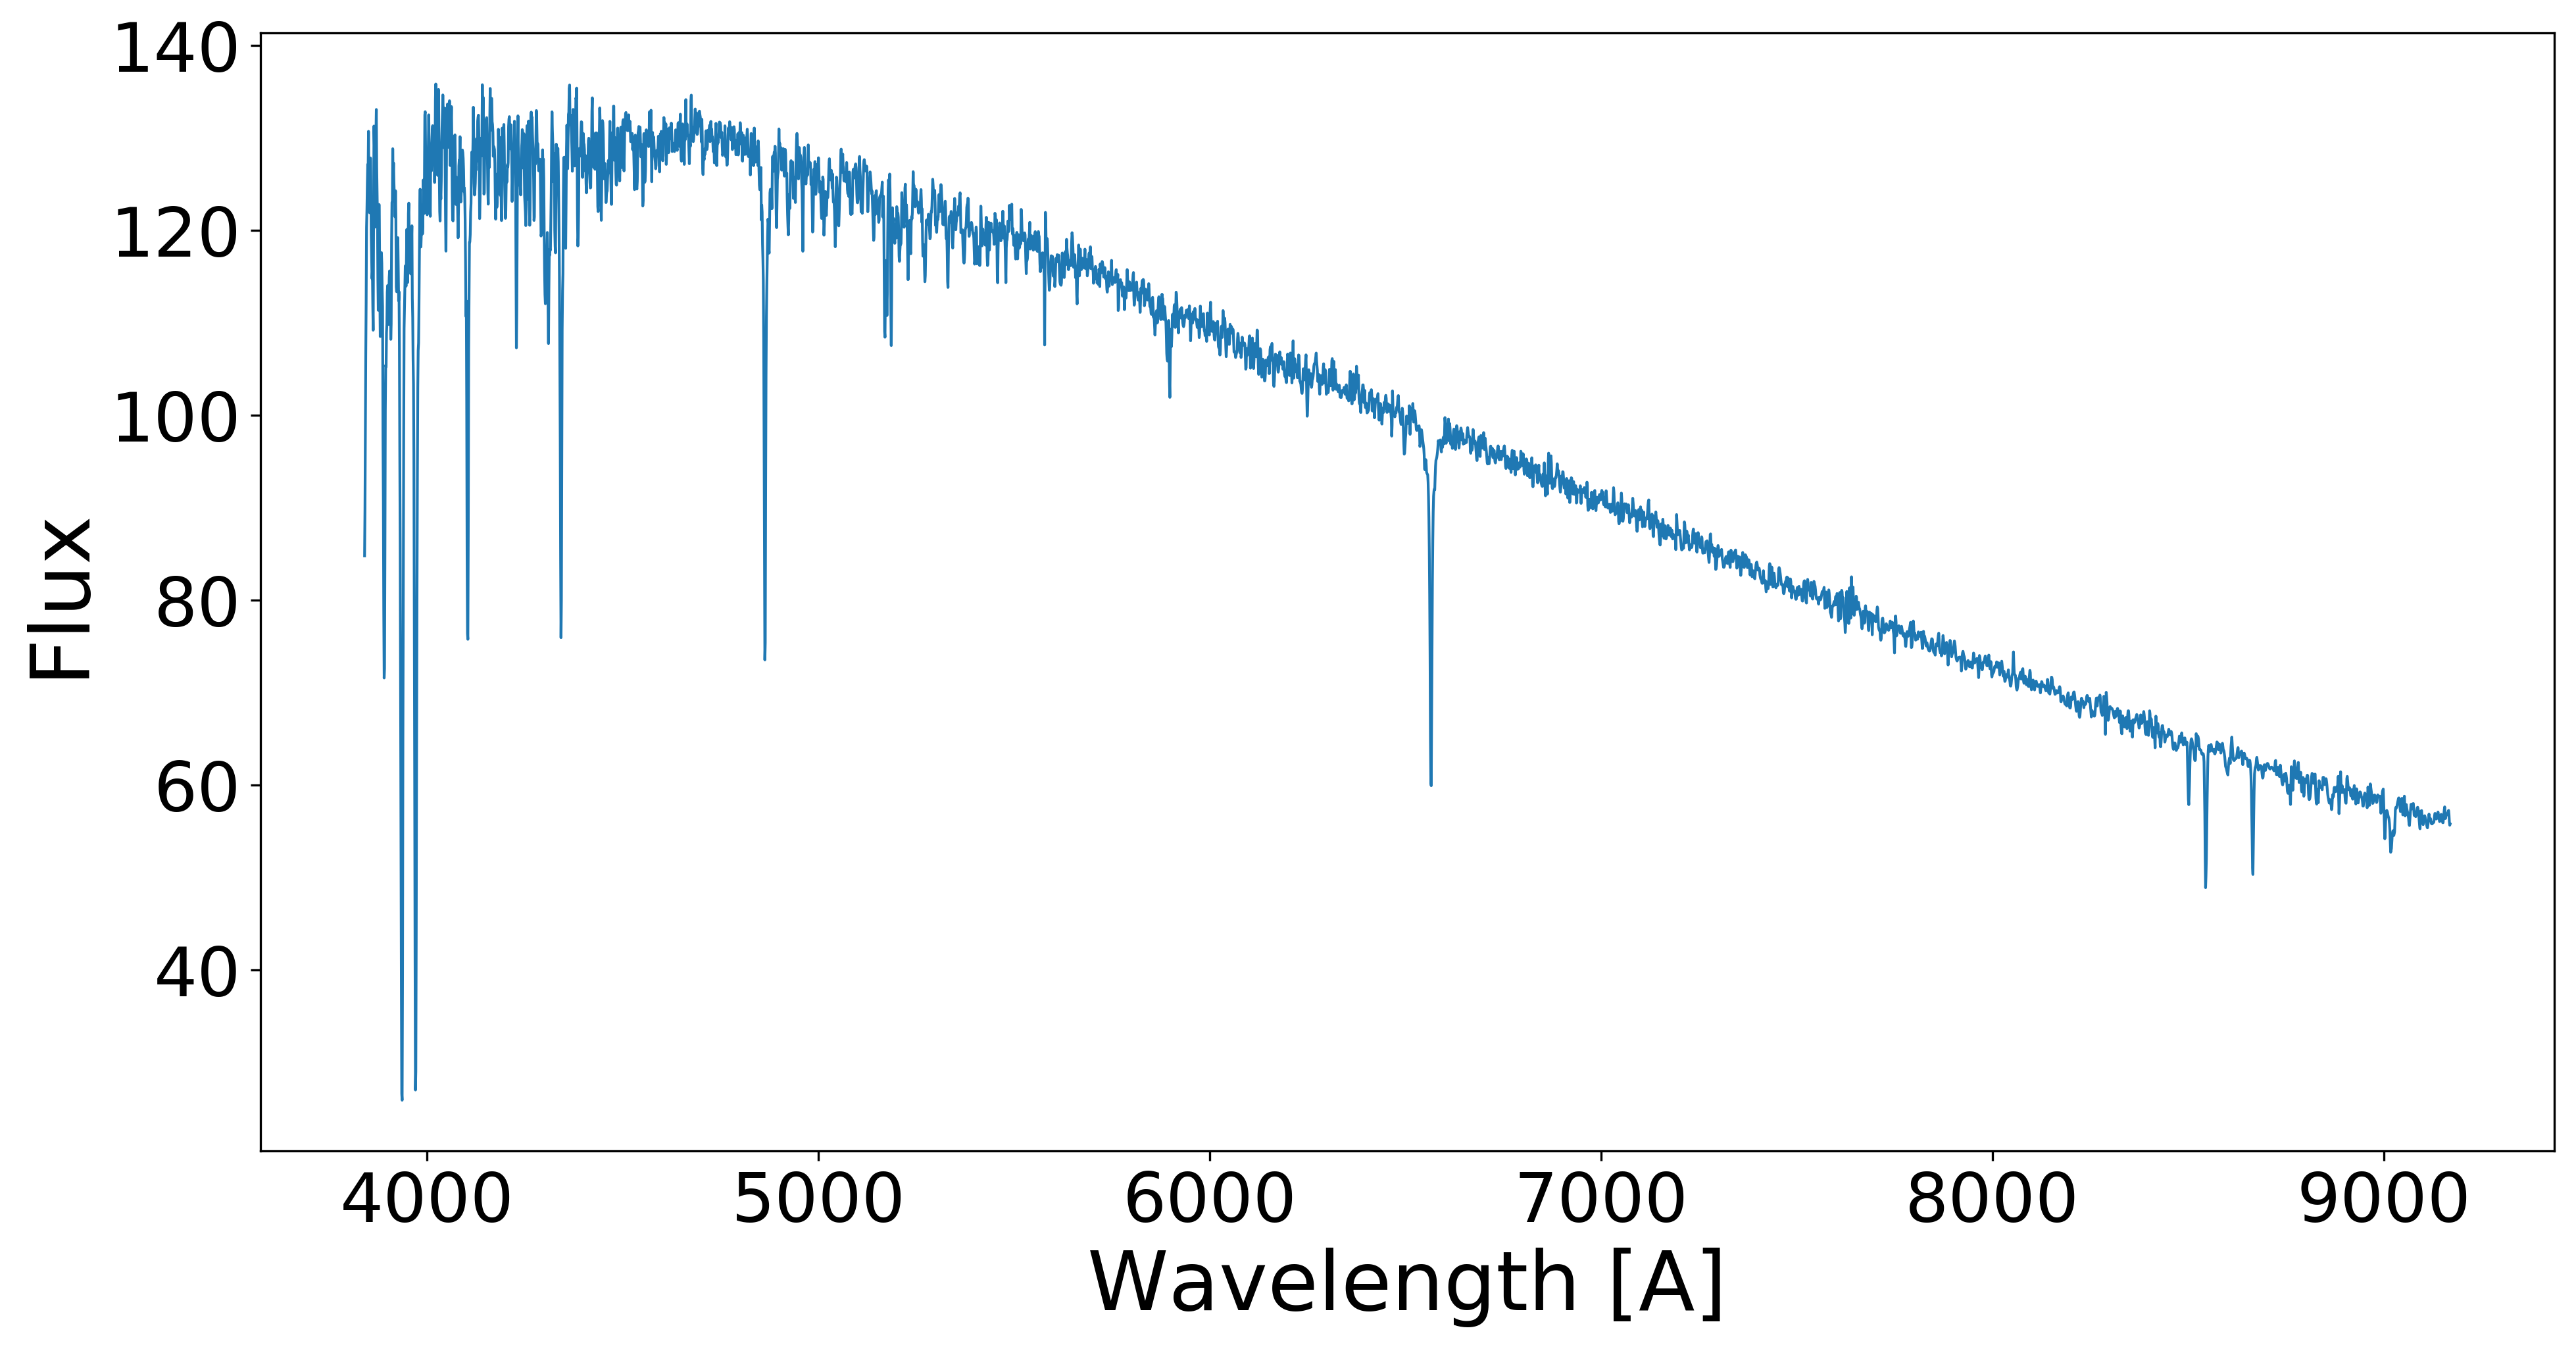

In [8]:
# a hot star
wavelength, flux, flux_err, mask = utils.read_in_optical_example()
    
# standardize the wavelength grid
wavelength, spectrum = utils.standardize_optical_spectrum(wavelength,flux)

# plot the spectrum
plt.xlabel("Wavelength [A]", size=30)
plt.ylabel("Flux", size=30)
plt.plot(wavelength, spectrum)


In [9]:
# median normalize the spectrum, the same way as the neural network training input 
spectrum_normalized = spectrum/float(np.median(spectrum)) - 1

# predict the class
from MWM_Classifier import testing
prediction_class = testing.predict_class(scaled_spectra = np.array([spectrum_normalized]),\
                            model = model_optical).data.numpy()

print("Probability of class [FGKM, Hot Stars, YSO, WD SB2, CV, WD] = [", 
        "%.2f " %(prediction_class[0][0]*100.),\
        "%.2f " %(prediction_class[0][1]*100.),\
        "%.2f " %(prediction_class[0][2]*100.),\
        "%.2f " %(prediction_class[0][3]*100.),\
        "%.2f " %(prediction_class[0][4]*100.),\
        "%.2f " %(prediction_class[0][5]*100.),\
        "]%")


Probability of class [FGKM, Hot Stars, YSO, WD SB2, CV, WD] = [ 100.00  0.00  0.00  0.00  0.00  0.00  ]%


> Predict classes in batch, and plot the confusion matrix (for the IR spectra.)

In [10]:
# predict class 
# x_valid_optical are the validation spectra
# y_valid are the true clases
y_pred_valid = testing.predict_class(scaled_spectra = x_valid_IR,\
                                     model = model_IR).data.numpy()


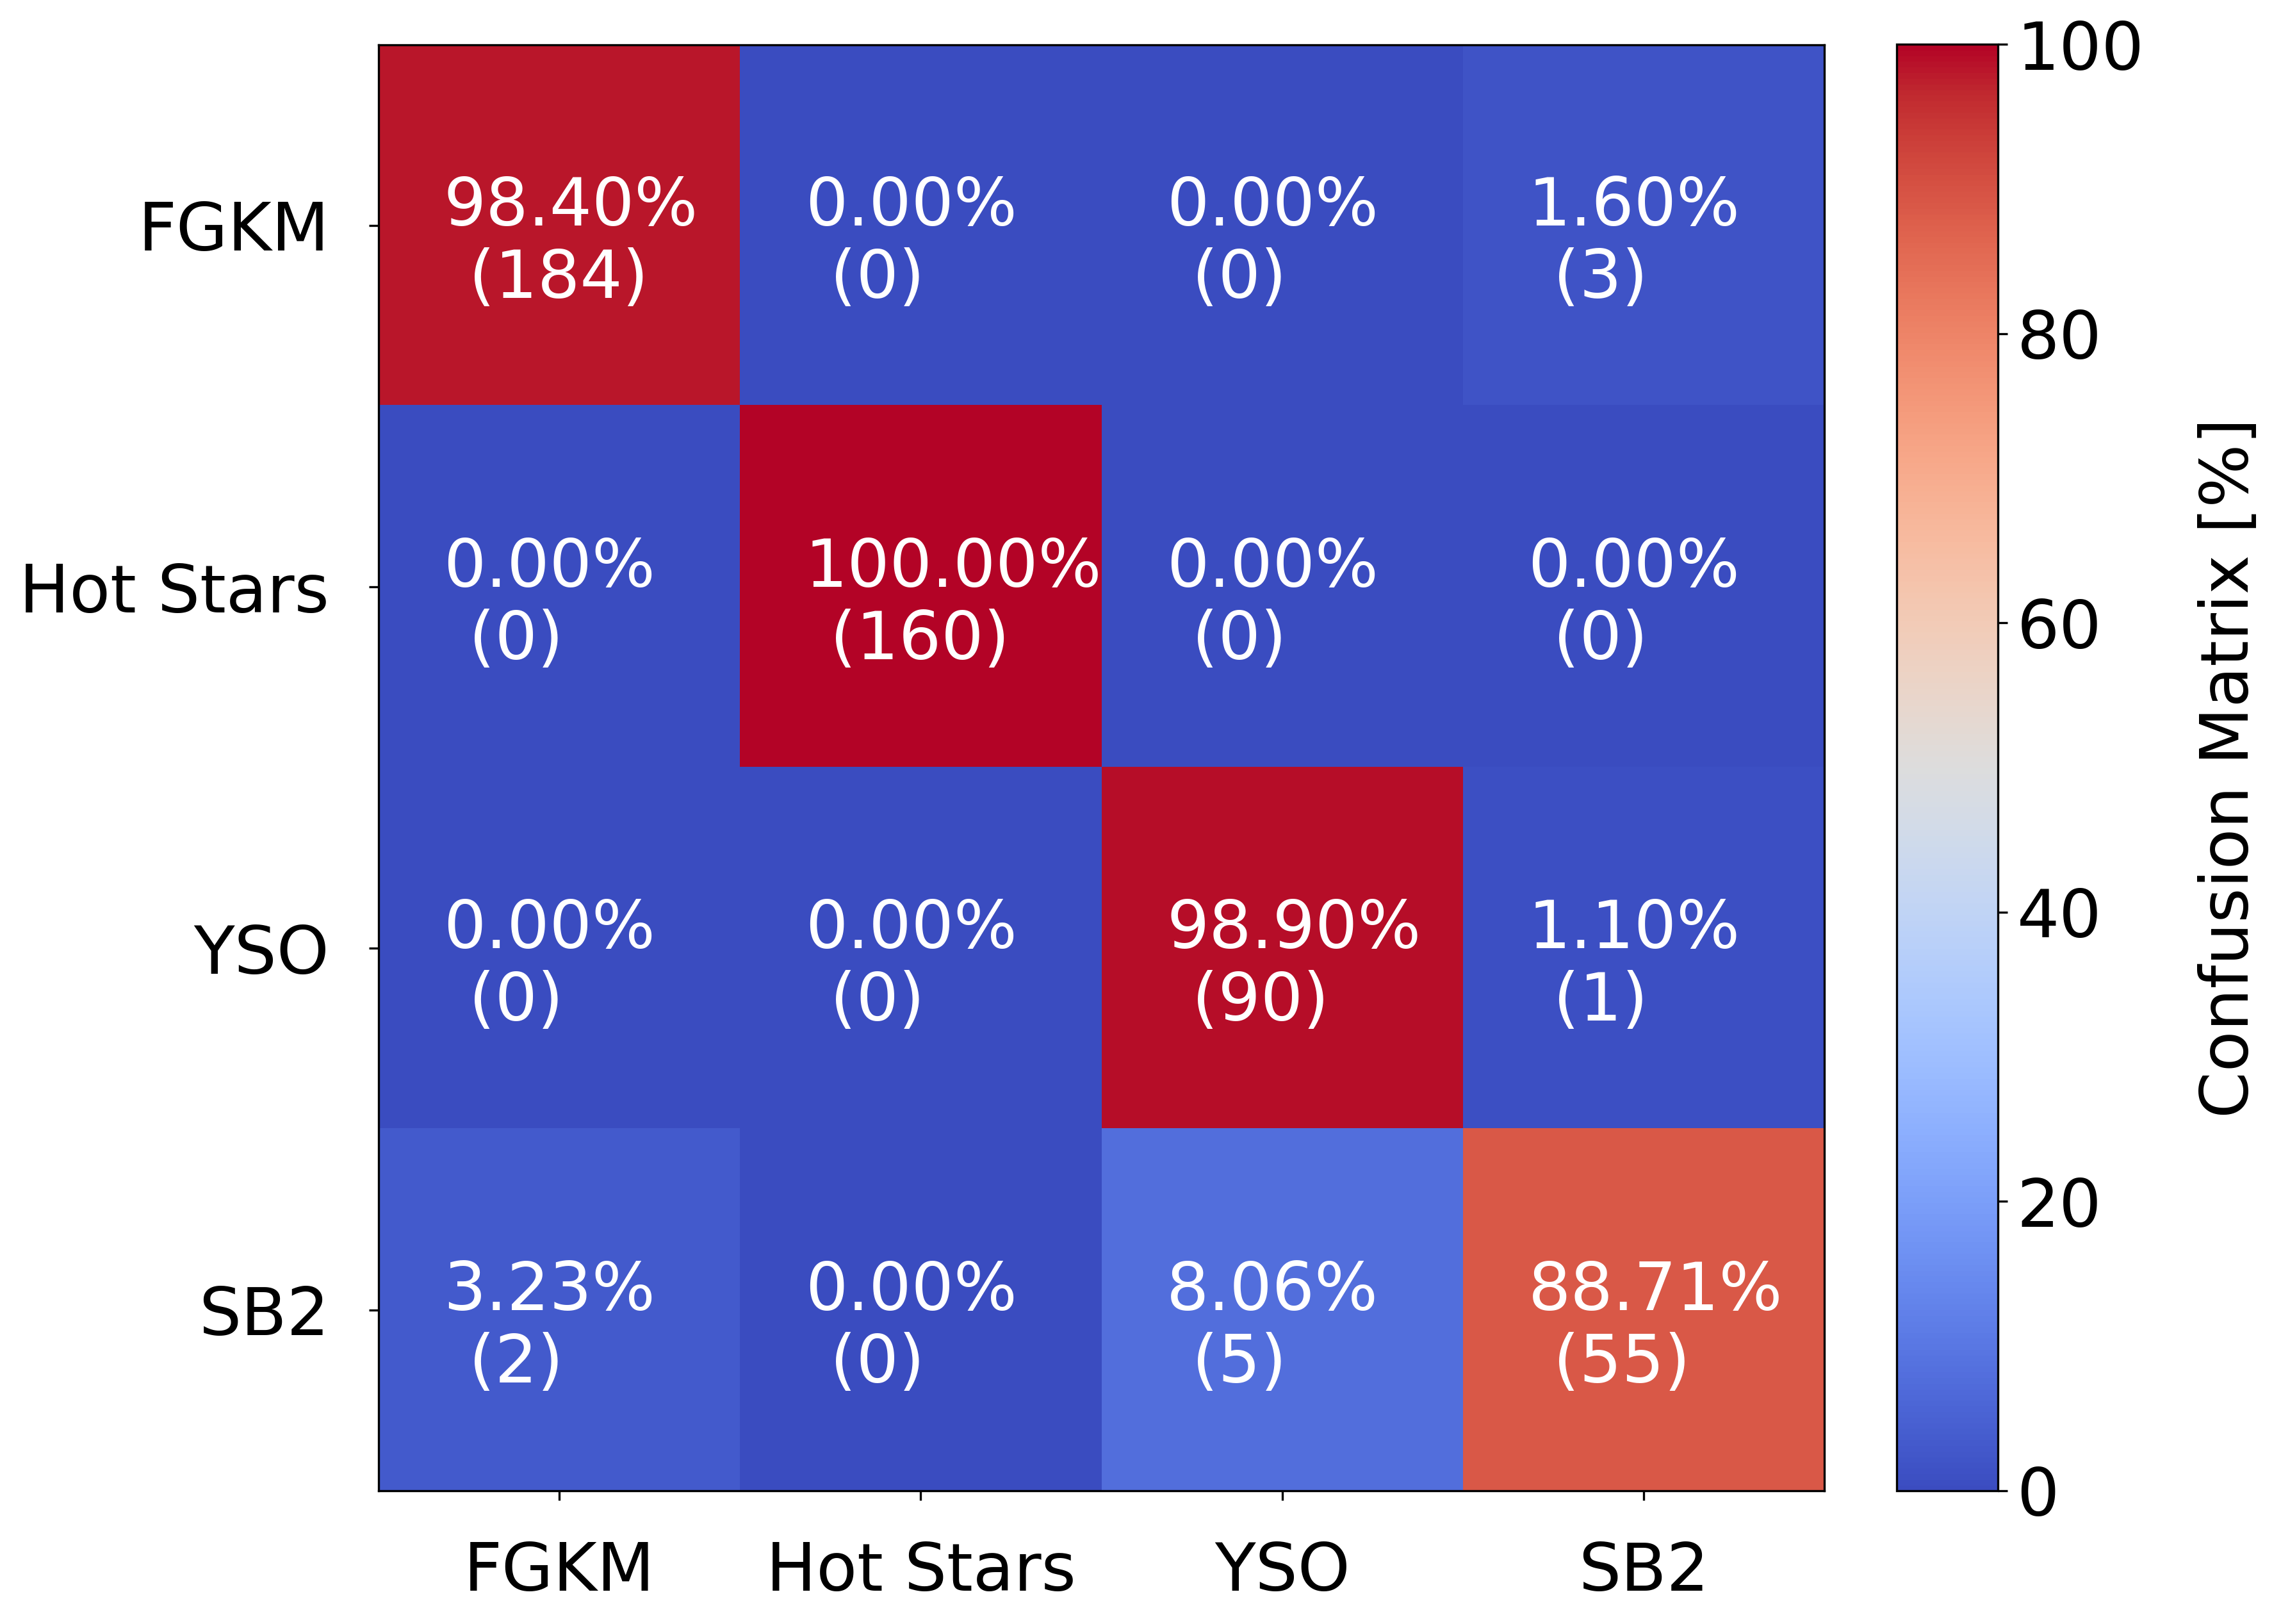

In [11]:
# find the maximum among the entries
y_valid_max = np.argmax(y_valid_IR, axis=1)
y_pred_valid_max = np.argmax(y_pred_valid, axis=1)

# calculate confusion matrix
confusion_matrix = np.zeros((4,4))
confusion_matrix_percentage = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        confusion_matrix[i,j] = np.sum((y_valid_max == i)*(y_pred_valid_max == j))
        confusion_matrix_percentage[i,j] = np.sum((y_valid_max == i)*(y_pred_valid_max == j))\
                                            /float(np.sum((y_valid_max == i)))*100.

        
#=============================================================================================
# initate results
fig = plt.figure(figsize=[12.,9.]);
ax = fig.gca();

ax.tick_params(axis='x', pad=15);
ax.tick_params(axis='y', pad=15);

#----------------------------------------------------------------------------------------------------
# plot results
hb = plt.imshow(confusion_matrix_percentage, cmap="coolwarm", vmin=0., vmax=100., zorder=0)

# plotting parameters
plt.xticks([0,1,2,3], ["FGKM", "Hot Stars", "YSO", "SB2"])
plt.yticks([0,1,2,3], ["FGKM", "Hot Stars", "YSO", "SB2"])

#----------------------------------------------------------------------------------------------------
# add the value of confusion matrix to the plot
for i in range(4):
    for j in range(4):
        plt.text(j-0.32, i, "%.2f" %confusion_matrix_percentage[i,j] +"%", color="white")
        plt.text(j-0.25, i+0.2, "(" + "%i" %confusion_matrix[i,j] + ")", color="white")
        
#----------------------------------------------------------------------------------------------------
# add color bar
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="5%")
cb = plt.colorbar(hb, cax=cax, orientation="vertical")
cb.ax.set_ylabel(r"Confusion Matrix [%]", labelpad=20)
plt.tight_layout(h_pad=0, w_pad=0)



> Do the same for optical_spectra.

In [12]:
# import packages
from MWM_Classifier import testing

# predict class 
# x_valid_optical are the validation spectra
# y_valid are the true clases
y_pred_valid = testing.predict_class(scaled_spectra = x_valid_optical,\
                                     model = model_optical).data.numpy()


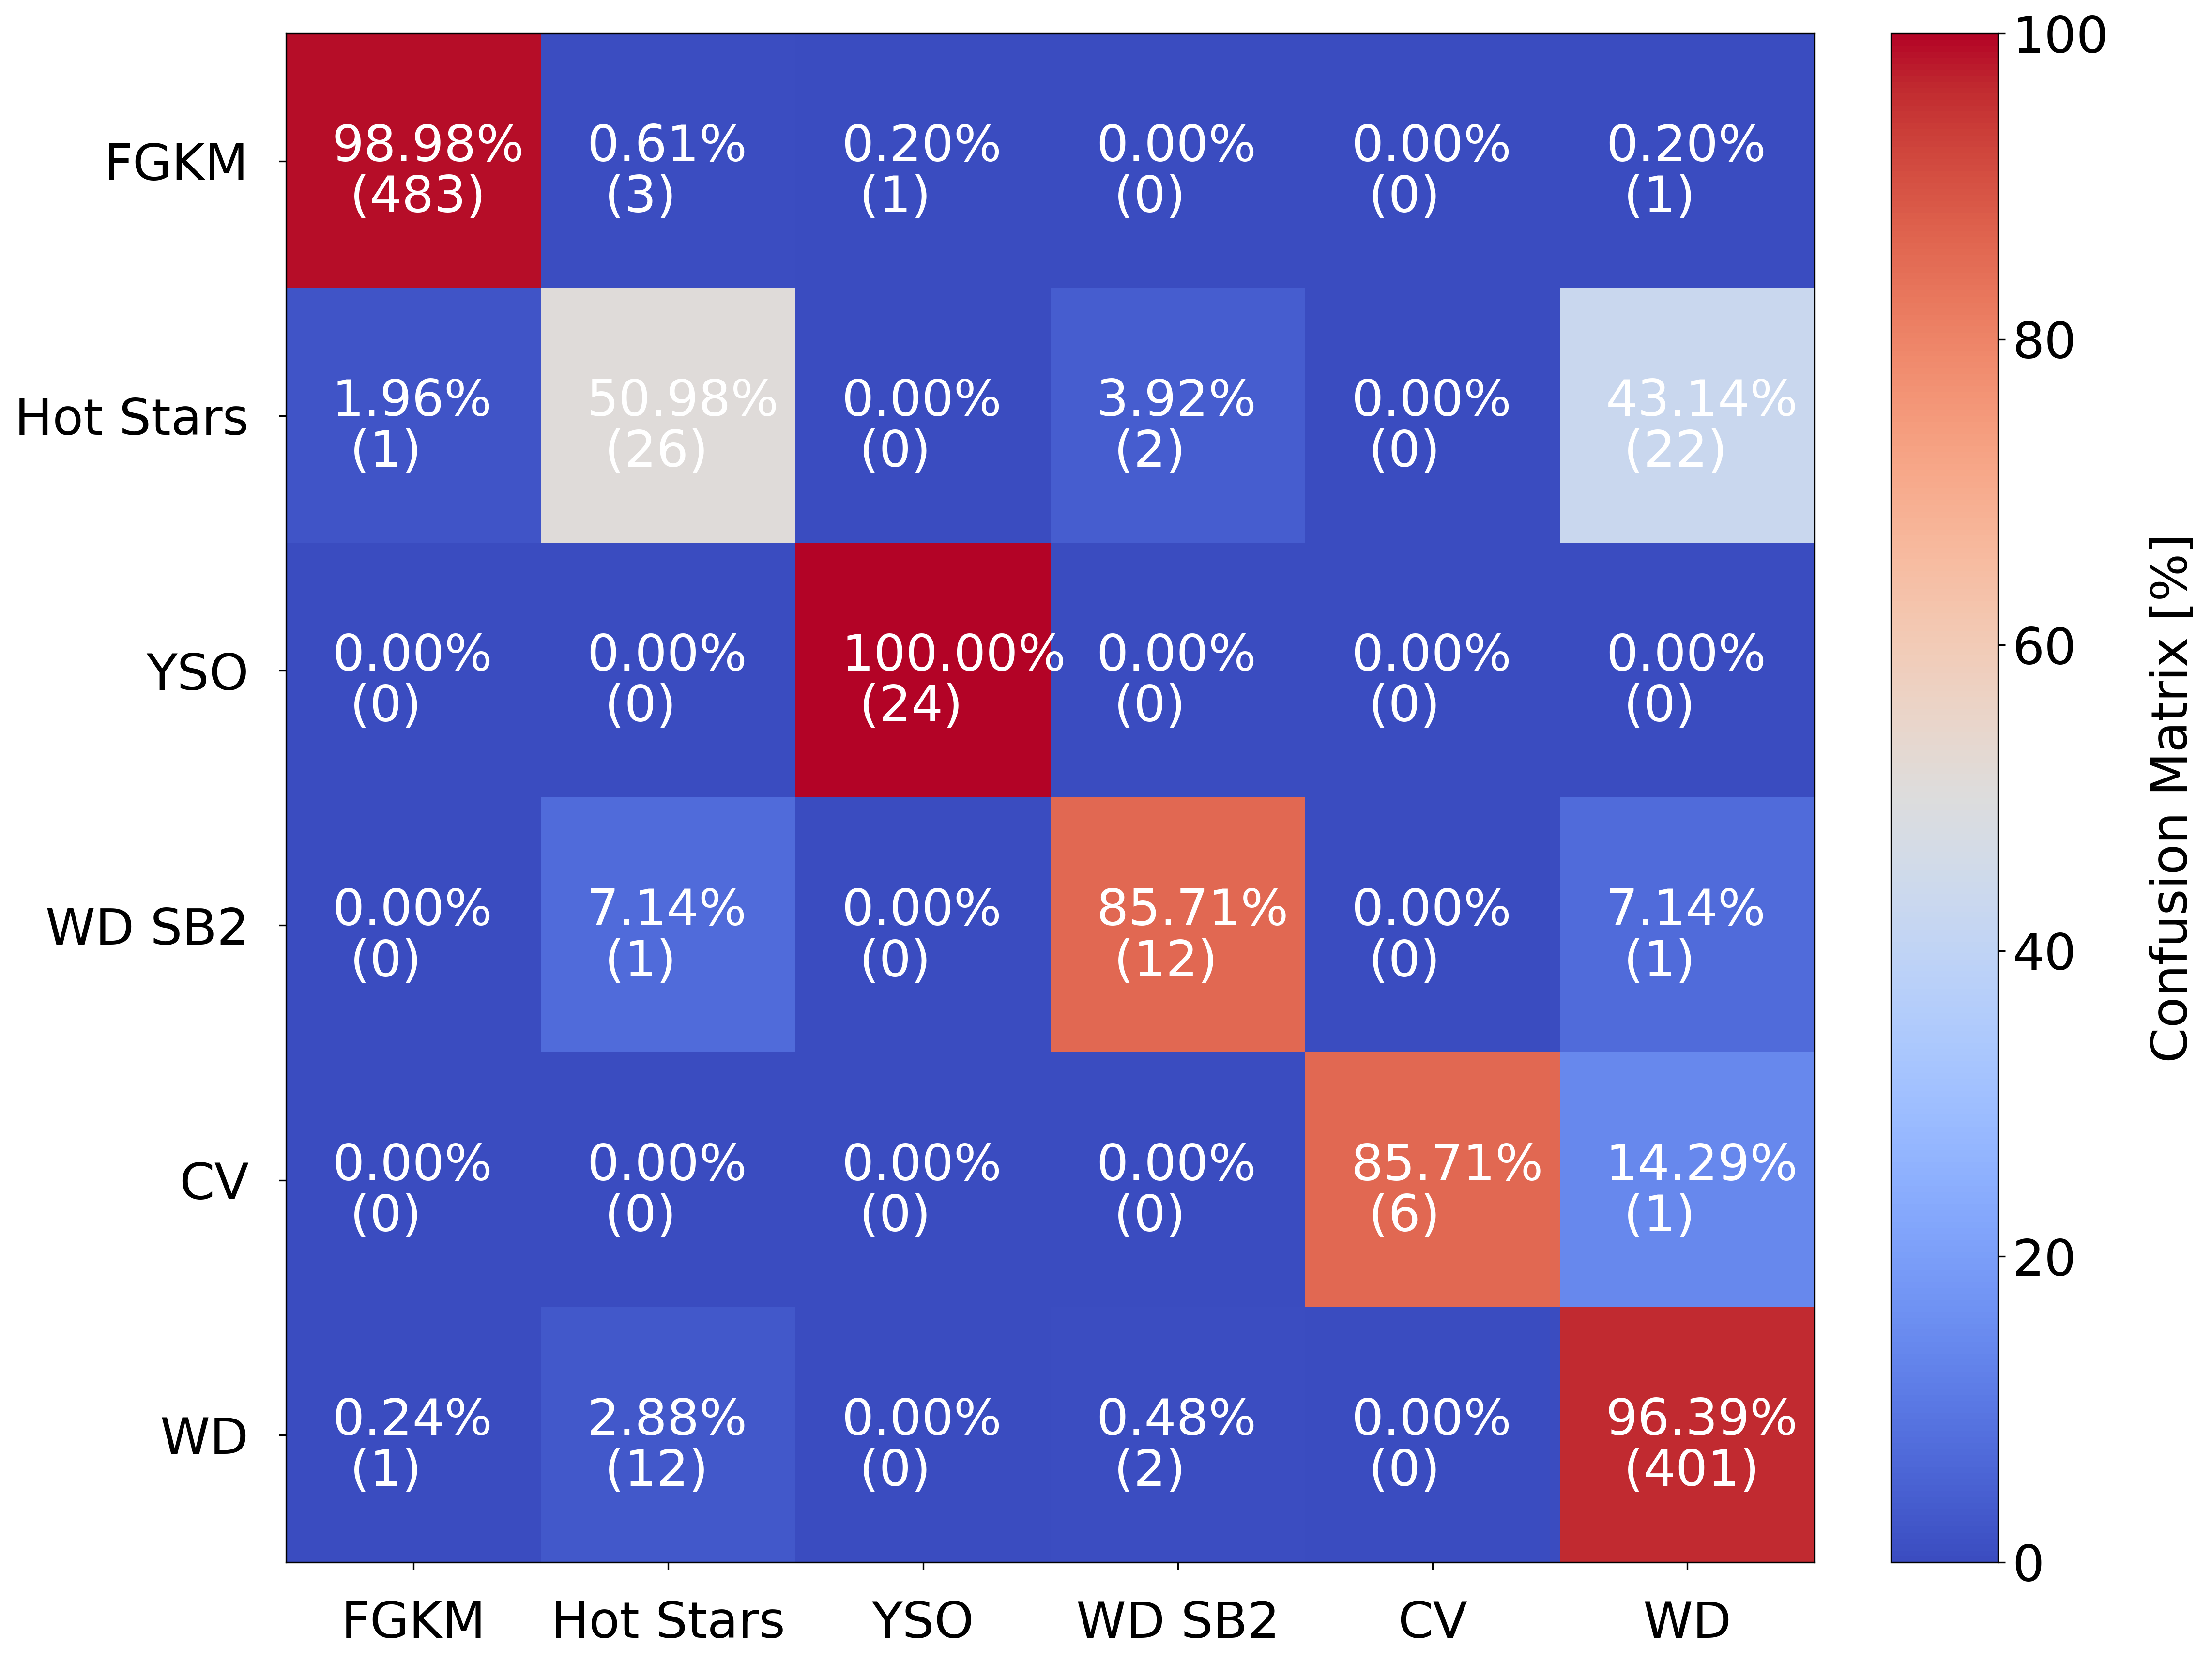

In [13]:
# find the maximum among the entries
y_valid_max = np.argmax(y_valid_optical, axis=1)
y_pred_valid_max = np.argmax(y_pred_valid, axis=1)

# calculate confusion matrix
confusion_matrix = np.zeros((6,6))
confusion_matrix_percentage = np.zeros((6,6))
for i in range(6):
    for j in range(6):
        confusion_matrix[i,j] = np.sum((y_valid_max == i)*(y_pred_valid_max == j))
        confusion_matrix_percentage[i,j] = np.sum((y_valid_max == i)*(y_pred_valid_max == j))\
                                            /float(np.sum((y_valid_max == i)))*100.

#=============================================================================================
# initate results
fig = plt.figure(figsize=[15.,12.]);
ax = fig.gca();

ax.tick_params(axis='x', pad=15);
ax.tick_params(axis='y', pad=15);

#----------------------------------------------------------------------------------------------------
# plot results
hb = plt.imshow(confusion_matrix_percentage, cmap="coolwarm", vmin=0., vmax=100., zorder=0)

# plotting parameters
plt.xticks([0,1,2,3,4,5], ["FGKM", "Hot Stars", "YSO", "WD SB2", "CV", "WD"])
plt.yticks([0,1,2,3,4,5], ["FGKM", "Hot Stars", "YSO", "WD SB2", "CV", "WD"])

#----------------------------------------------------------------------------------------------------
# add the value of confusion matrix to the plot
for i in range(6):
    for j in range(6):
        plt.text(j-0.32, i, "%.2f" %confusion_matrix_percentage[i,j] +"%", color="white")
        plt.text(j-0.25, i+0.2, "(" + "%i" %confusion_matrix[i,j] + ")", color="white")
        
#----------------------------------------------------------------------------------------------------
# add color bar
ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="7%", pad="5%")
cb = plt.colorbar(hb, cax=cax, orientation="vertical")
cb.ax.set_ylabel(r"Confusion Matrix [%]", labelpad=20)
plt.tight_layout(h_pad=0, w_pad=0)


## Training the network (need GPU).

> Retrain the IR network.

In [ ]:
# import packages
import numpy as np
from MWM_Classifier import training


#=============================================================================================
# restore training spectra
temp = np.load("optical_spectra.npz")

spectra_fgkm = temp["spectra_fgkm"]
spectra_err_fgkm = temp["spectra_err_fgkm"]

spectra_hotstars = temp["spectra_hotstars"]
spectra_err_hotstars = temp["spectra_err_hotstars"]

spectra_yso = temp["spectra_yso"]
spectra_err_yso = temp["spectra_err_yso"]

spectra_wdsb2 = temp["spectra_wdsb2"]
spectra_err_wdsb2 = temp["spectra_err_wdsb2"]

spectra_cv = temp["spectra_cv"]
spectra_err_cv = temp["spectra_err_cv"]

spectra_wd = temp["spectra_wd"]
spectra_err_wd = temp["spectra_err_wd"]

#------------------------------------------------------------------------------
# group all the spectra
ind_group = np.concatenate([np.ones(spectra_fgkm.shape[0])*0,\
                            np.ones(spectra_hotstars.shape[0])*1,\
                            np.ones(spectra_yso.shape[0])*2,\
                            np.ones(spectra_wdsb2.shape[0])*3,\
                            np.ones(spectra_cv.shape[0])*4,\
                            np.ones(spectra_wd.shape[0])*5]).astype("int")
spectra = np.vstack([spectra_fgkm, spectra_hotstars, spectra_yso,\
                     spectra_wdsb2, spectra_cv, spectra_wd])
spectra_err = np.vstack([spectra_err_fgkm, spectra_err_hotstars,\
                         spectra_err_yso, spectra_err_wdsb2, spectra_err_cv,\
                         spectra_err_wd])

# number of training data (the rest to be validation)
num_train = 12000

#-----------------------------------------------------------------------------
# normalize, since we dealing with flux spectra
median_val = np.median(spectra,axis=1)
spectra = (spectra.T/median_val).T
spectra_err = (spectra_err.T/median_val).T
spectra = spectra[median_val > 0,:]
spectra_err = spectra_err[median_val > 0,:]
ind_group = ind_group[median_val > 0]

# make output array
y_ind = np.zeros((ind_group.size,np.max(ind_group)+1))
for i in range(np.max(ind_group)+1):
    y_ind[ind_group == i,i] = 1.

#-----------------------------------------------------------------------------
# shuffle arrays
ind_shuffle = np.arange(ind_group.size)
np.random.shuffle(ind_shuffle)
spectra = spectra[ind_shuffle,:]
y_ind = y_ind[ind_shuffle,:]

# shift input to between -0.5,0.5
spectra = spectra - 1.

# break into training and validation set
training_spectra = spectra[:num_train,:]
validation_spectra = spectra[num_train:,:]
training_labels = y_ind[:num_train,:]
validation_labels = y_ind[num_train:,:]


#=============================================================================================
# save the validation spectra
np.savez("Optical_validation_spectra.npz",\
         validation_spectra = validation_spectra,\
         validation_labels = validation_labels)

# training the network
training.neural_net(training_spectra, training_labels, validation_spectra, validation_labels,\
                    num_channels=8, num_neurons = 30, mask_size=5, stride_size=3,\
                    wavelength_note = "optical",
                    num_steps=1e3, learning_rate=1e-4, batch_size=256)


In [ ]:

# import packages
import numpy as np
from MWM_Classifier import training


#=============================================================================================
# restore training spectra
# NIR spectra
# see loadspec.py for details on the data curation

# load spectra
temp = np.load("nir_spectra.npz")

spectra_fgkm = temp["spectra_fgkm"]
spectra_err_fgkm = temp["spectra_err_fgkm"]

spectra_hotstars = temp["spectra_hotstars"]
spectra_err_hotstars = temp["spectra_err_hotstars"]

spectra_yso = temp["spectra_yso"]
spectra_err_yso = temp["spectra_err_yso"]

spectra_sb2 = temp["spectra_sb2"]
spectra_err_sb2 = temp["spectra_err_sb2"]

# number of training set
num_train=30000

#-----------------------------------------------------------------------------
# group all the spectra
ind_group = np.concatenate([np.ones(spectra_fgkm.shape[0])*0,\
                            np.ones(spectra_hotstars.shape[0])*1,\
                            np.ones(spectra_yso.shape[0])*2,\
                            np.ones(spectra_sb2.shape[0])*3]).astype("int")
spectra = np.vstack([spectra_fgkm, spectra_hotstars, spectra_yso, spectra_sb2])
spectra_err = np.vstack([spectra_err_fgkm, spectra_err_hotstars,\
                         spectra_err_yso, spectra_err_sb2])

#-----------------------------------------------------------------------------
# normalize, since we dealing with flux spectra
median_val = np.median(spectra,axis=1)
spectra = (spectra.T/median_val).T
spectra_err = (spectra_err.T/median_val).T
spectra = spectra[median_val > 0,:]
spectra_err = spectra_err[median_val > 0,:]
ind_group = ind_group[median_val > 0]

# make output array
y_ind = np.zeros((ind_group.size,np.max(ind_group)+1))
for i in range(np.max(ind_group)+1):
    y_ind[ind_group == i,i] = 1.

#-----------------------------------------------------------------------------
# shuffle arrays
ind_shuffle = np.arange(ind_group.size)
np.random.shuffle(ind_shuffle)
spectra = spectra[ind_shuffle,:]
y_ind = y_ind[ind_shuffle,:]

# shift input to between -0.5,0.5
spectra = spectra - 1.

# break into training and validation set
training_spectra = spectra[:num_train,:]
validation_spectra = spectra[num_train:,:]
training_labels = y_ind[:num_train,:]
validation_labels = y_ind[num_train:,:]


#=============================================================================================
# save the validation spectra
np.savez("IR_validation_spectra.npz",\
         validation_spectra = validation_spectra,\
         validation_labels = validation_labels)

# training the network
training.neural_net(training_spectra, training_labels, validation_spectra, validation_labels,\
                    wavelength_note = "IR",\
                    num_channels=8, num_neurons = 30, mask_size=5, stride_size=3,\
                    num_steps=1e3, learning_rate=1e-4, batch_size=256)
